In [3]:
!pip install thefuzz

In [4]:
!pip install python-Levenshtein

In [5]:
!pip install kneed

In [6]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime
from thefuzz import process, fuzz
from collections import defaultdict
from kneed import KneeLocator
from dateutil.relativedelta import relativedelta
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.impute import KNNImputer
from sklearn.metrics.pairwise import cosine_similarity
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import warnings
import joblib
warnings.filterwarnings('ignore')

1. Data Pre-processing

In [10]:
# Load the dataset
data = pd.read_csv('C:/Users/Owinyez/Downloads/Stock Prices Data Set.CSV')

# Display the first few rows of the dataset
data.head()

,symbol,date,open,high,low,close,volume
0,AAL,2014-01-02,25.0700,25.8200,25.0600,25.3600,8998943
1,AAPL,2014-01-02,79.3828,79.5756,78.8601,79.0185,58791957
2,AAP,2014-01-02,110.3600,111.8800,109.2900,109.7400,542711
3,ABBV,2014-01-02,52.1200,52.3300,51.5200,51.9800,4569061
4,ABC,2014-01-02,70.1100,70.2300,69.4800,69.8900,1148391


1.1 Explore the dataset

In [11]:
# check number of rows and columns
data.shape

(497472, 7)

In [12]:
# explore data types and null values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497472 entries, 0 to 497471
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   symbol  497472 non-null  object 
 1   date    497472 non-null  object 
 2   open    497461 non-null  float64
 3   high    497464 non-null  float64
 4   low     497464 non-null  float64
 5   close   497472 non-null  float64
 6   volume  497472 non-null  int64  
dtypes: float64(4), int64(1), object(2)
memory usage: 26.6+ MB


In [13]:
# Check the count of symbols 
data['symbol'].nunique()

505

1.2 Data Cleaning

1.2.1 Handling Missing Values

In [14]:
# check for Missing Values
data.isnull().sum()

symbol     0
date       0
open      11
high       8
low        8
close      0
volume     0
dtype: int64

In [15]:
# Total missing values
data.isnull().sum().sum()

27

In [16]:
# Drop null values
data = data.dropna(subset=['open','high', 'low'])

# Total missing values
data.isnull().sum().sum()

0

1.2.2 Dealing with duplicates

In [17]:
# Check for duplicate rows based on all columns
print(f"Number of duplicate rows: {data.duplicated().sum()}")

Number of duplicate rows: 0


In [19]:
#sort by symbol
data_sorted = data.sort_values(by='symbol')

#show data sample
data.head()

,symbol,date,open,high,low,close,volume
0,AAL,2014-01-02,25.0700,25.8200,25.0600,25.3600,8998943
1,AAPL,2014-01-02,79.3828,79.5756,78.8601,79.0185,58791957
2,AAP,2014-01-02,110.3600,111.8800,109.2900,109.7400,542711
3,ABBV,2014-01-02,52.1200,52.3300,51.5200,51.9800,4569061
4,ABC,2014-01-02,70.1100,70.2300,69.4800,69.8900,1148391


1.2.3 Handling outliers

In [20]:
# Display datatypes
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 497461 entries, 0 to 497471
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   symbol  497461 non-null  object 
 1   date    497461 non-null  object 
 2   open    497461 non-null  float64
 3   high    497461 non-null  float64
 4   low     497461 non-null  float64
 5   close   497461 non-null  float64
 6   volume  497461 non-null  int64  
dtypes: float64(4), int64(1), object(2)
memory usage: 30.4+ MB


In [23]:
#check for numerical outliers
# Z-score method
from scipy.stats import zscore
data['z_close'] = zscore(data['close'])
outliers = data[abs(data['z_close']) > 3]

data.head()

,symbol,date,open,high,low,close,volume,z_close
0,AAL,2014-01-02,25.0700,25.8200,25.0600,25.3600,8998943,-0.601239
1,AAPL,2014-01-02,79.3828,79.5756,78.8601,79.0185,58791957,-0.072435
2,AAP,2014-01-02,110.3600,111.8800,109.2900,109.7400,542711,0.230325
3,ABBV,2014-01-02,52.1200,52.3300,51.5200,51.9800,4569061,-0.338899
4,ABC,2014-01-02,70.1100,70.2300,69.4800,69.8900,1148391,-0.162396


In [25]:
data.shape

(497461, 8)

<Axes: xlabel='close'>

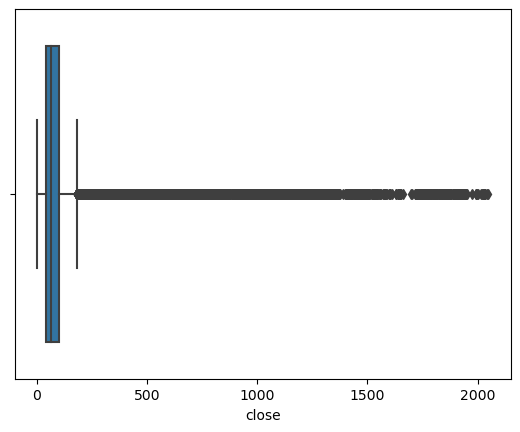

In [26]:
# visualize outliers

import seaborn as sns
sns.boxplot(x=data['close'])


NB: No outliers detected, however, I prefer to keep the z_close column for future analysis

In [29]:
data.shape

(497452, 8)

9 rows were dropped, initial minor data entry issues

2. Feature Engineering

In [31]:
#rolling averages and volatility
data['MA7'] = data.groupby('symbol')['close'].transform(lambda x: x.rolling(7).mean())
data['Volatility'] = data.groupby('symbol')['close'].transform(lambda x: x.rolling(7).std())
data['Return'] = data.groupby('symbol')['close'].pct_change()

data.head()


,symbol,date,open,high,low,close,volume,z_close,MA7,Volatility,Return
0,AAL,2014-01-02,25.0700,25.8200,25.0600,25.3600,8998943,-0.601239,NaN,NaN,NaN
1,AAPL,2014-01-02,79.3828,79.5756,78.8601,79.0185,58791957,-0.072435,NaN,NaN,NaN
2,AAP,2014-01-02,110.3600,111.8800,109.2900,109.7400,542711,0.230325,NaN,NaN,NaN
3,ABBV,2014-01-02,52.1200,52.3300,51.5200,51.9800,4569061,-0.338899,NaN,NaN,NaN
4,ABC,2014-01-02,70.1100,70.2300,69.4800,69.8900,1148391,-0.162396,NaN,NaN,NaN


In [34]:
#feature lagging time series predictors
data['lag_1_close'] = data.groupby('symbol')['close'].shift(1)
data['lag_7_volume'] = data.groupby('symbol')['volume'].shift(7)

data.head()

,symbol,date,open,high,low,close,volume,z_close,MA7,Volatility,Return,lag_1_close,lag_7_volume
0,AAL,2014-01-02,25.0700,25.8200,25.0600,25.3600,8998943,-0.601239,NaN,NaN,NaN,NaN,NaN
1,AAPL,2014-01-02,79.3828,79.5756,78.8601,79.0185,58791957,-0.072435,NaN,NaN,NaN,NaN,NaN
2,AAP,2014-01-02,110.3600,111.8800,109.2900,109.7400,542711,0.230325,NaN,NaN,NaN,NaN,NaN
3,ABBV,2014-01-02,52.1200,52.3300,51.5200,51.9800,4569061,-0.338899,NaN,NaN,NaN,NaN,NaN
4,ABC,2014-01-02,70.1100,70.2300,69.4800,69.8900,1148391,-0.162396,NaN,NaN,NaN,NaN,NaN


In [36]:
#calculate daily retuns in percentage

data['Daily_Return'] = data.groupby('symbol')['close'].pct_change()
data['Daily_Return (%)'] = data['Daily_Return'] * 100

data.head()

,symbol,date,open,high,low,close,volume,z_close,MA7,Volatility,Return,lag_1_close,lag_7_volume,Daily_Return,Daily_Return (%)
0,AAL,2014-01-02,25.0700,25.8200,25.0600,25.3600,8998943,-0.601239,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AAPL,2014-01-02,79.3828,79.5756,78.8601,79.0185,58791957,-0.072435,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AAP,2014-01-02,110.3600,111.8800,109.2900,109.7400,542711,0.230325,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ABBV,2014-01-02,52.1200,52.3300,51.5200,51.9800,4569061,-0.338899,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ABC,2014-01-02,70.1100,70.2300,69.4800,69.8900,1148391,-0.162396,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
!pip install thefuzz

In [4]:
!pip install python-Levenshtein

In [5]:
!pip install kneed

In [6]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime
from thefuzz import process, fuzz
from collections import defaultdict
from kneed import KneeLocator
from dateutil.relativedelta import relativedelta
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.impute import KNNImputer
from sklearn.metrics.pairwise import cosine_similarity
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import warnings
import joblib
warnings.filterwarnings('ignore')

In [8]:
# Load the dataset
data = pd.read_csv('D:/Users/Owinyez/Documents/Projos/Codveda/MyData/Stock Prices Cleaned Dataset.CSV')

# Display the first few rows of the dataset
data.head()

,symbol,date,open,high,low,close,volume,z_close,MA7,Volatility,Return,lag_1_close,lag_7_volume,Daily_Return,Daily_Return (%)
0,AAL,2014-01-02,25.0700,25.8200,25.0600,25.3600,8998943,-0.601239,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AAPL,2014-01-02,79.3828,79.5756,78.8601,79.0185,58791957,-0.072435,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AAP,2014-01-02,110.3600,111.8800,109.2900,109.7400,542711,0.230325,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ABBV,2014-01-02,52.1200,52.3300,51.5200,51.9800,4569061,-0.338899,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ABC,2014-01-02,70.1100,70.2300,69.4800,69.8900,1148391,-0.162396,NaN,NaN,NaN,NaN,NaN,NaN,NaN


3. Correcting Errors

In [14]:
#converting dates
data['date'] = pd.to_datetime(data['date'])

data.head()

,symbol,date,open,high,low,close,volume,z_close,MA7,Volatility,Return,lag_1_close,lag_7_volume,Daily_Return,Daily_Return (%)
57,A,2014-01-02,57.10,57.100,56.15,56.21,1916160,-0.297213,NaN,NaN,NaN,NaN,NaN,NaN,NaN
540,A,2014-01-03,56.39,57.345,56.26,56.92,1866651,-0.290216,NaN,NaN,0.012631,56.21,NaN,0.012631,1.263120
1023,A,2014-01-06,57.40,57.700,56.56,56.64,1777472,-0.292975,NaN,NaN,-0.004919,56.92,NaN,-0.004919,-0.491918
1506,A,2014-01-07,56.95,57.630,56.93,57.45,1463208,-0.284992,NaN,NaN,0.014301,56.64,NaN,0.014301,1.430085
1989,A,2014-01-08,57.33,58.540,57.17,58.39,2659468,-0.275729,NaN,NaN,0.016362,57.45,NaN,0.016362,1.636205


In [13]:
#sorting values
data = data.sort_values(by=['symbol', 'date'])

data.head()

,symbol,date,open,high,low,close,volume,z_close,MA7,Volatility,Return,lag_1_close,lag_7_volume,Daily_Return,Daily_Return (%)
57,A,2014-01-02,57.10,57.100,56.15,56.21,1916160,-0.297213,NaN,NaN,NaN,NaN,NaN,NaN,NaN
540,A,2014-01-03,56.39,57.345,56.26,56.92,1866651,-0.290216,NaN,NaN,0.012631,56.21,NaN,0.012631,1.263120
1023,A,2014-01-06,57.40,57.700,56.56,56.64,1777472,-0.292975,NaN,NaN,-0.004919,56.92,NaN,-0.004919,-0.491918
1506,A,2014-01-07,56.95,57.630,56.93,57.45,1463208,-0.284992,NaN,NaN,0.014301,56.64,NaN,0.014301,1.430085
1989,A,2014-01-08,57.33,58.540,57.17,58.39,2659468,-0.275729,NaN,NaN,0.016362,57.45,NaN,0.016362,1.636205


In [16]:
#Rolling averages & volatility
data['MA7'] = data.groupby('symbol')['close'].transform(lambda x: x.rolling(window=7).mean())
data['Volatility'] = data.groupby('symbol')['close'].transform(lambda x: x.rolling(window=7).std())

data.head()

,symbol,date,open,high,low,close,volume,z_close,MA7,Volatility,Return,lag_1_close,lag_7_volume,Daily_Return,Daily_Return (%)
57,A,2014-01-02,57.10,57.100,56.15,56.21,1916160,-0.297213,NaN,NaN,NaN,NaN,NaN,NaN,NaN
540,A,2014-01-03,56.39,57.345,56.26,56.92,1866651,-0.290216,NaN,NaN,0.012631,56.21,NaN,0.012631,1.263120
1023,A,2014-01-06,57.40,57.700,56.56,56.64,1777472,-0.292975,NaN,NaN,-0.004919,56.92,NaN,-0.004919,-0.491918
1506,A,2014-01-07,56.95,57.630,56.93,57.45,1463208,-0.284992,NaN,NaN,0.014301,56.64,NaN,0.014301,1.430085
1989,A,2014-01-08,57.33,58.540,57.17,58.39,2659468,-0.275729,NaN,NaN,0.016362,57.45,NaN,0.016362,1.636205


In [18]:
# Lag features
data['Lag_1_close'] = data.groupby('symbol')['close'].shift(1)
data['Lag_7_volume'] = data.groupby('symbol')['volume'].shift(7)

data.head()

,symbol,date,open,high,low,close,volume,z_close,MA7,Volatility,Return,lag_1_close,lag_7_volume,Daily_Return,Daily_Return (%),Lag_1_close,Lag_7_volume
57,A,2014-01-02,57.10,57.100,56.15,56.21,1916160,-0.297213,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
540,A,2014-01-03,56.39,57.345,56.26,56.92,1866651,-0.290216,NaN,NaN,0.012631,56.21,NaN,0.012631,1.263120,56.21,NaN
1023,A,2014-01-06,57.40,57.700,56.56,56.64,1777472,-0.292975,NaN,NaN,-0.004919,56.92,NaN,-0.004919,-0.491918,56.92,NaN
1506,A,2014-01-07,56.95,57.630,56.93,57.45,1463208,-0.284992,NaN,NaN,0.014301,56.64,NaN,0.014301,1.430085,56.64,NaN
1989,A,2014-01-08,57.33,58.540,57.17,58.39,2659468,-0.275729,NaN,NaN,0.016362,57.45,NaN,0.016362,1.636205,57.45,NaN


In [19]:
# Drop null and duplicate columns
data = data.drop(columns=['MA7', 'Volatility', 'lag_7_volume', 'lag_1_close',])

# Check DataFrame
data.head()

,symbol,date,open,high,low,close,volume,z_close,Return,Daily_Return,Daily_Return (%),Lag_1_close,Lag_7_volume
57,A,2014-01-02,57.10,57.100,56.15,56.21,1916160,-0.297213,NaN,NaN,NaN,NaN,NaN
540,A,2014-01-03,56.39,57.345,56.26,56.92,1866651,-0.290216,0.012631,0.012631,1.263120,56.21,NaN
1023,A,2014-01-06,57.40,57.700,56.56,56.64,1777472,-0.292975,-0.004919,-0.004919,-0.491918,56.92,NaN
1506,A,2014-01-07,56.95,57.630,56.93,57.45,1463208,-0.284992,0.014301,0.014301,1.430085,56.64,NaN
1989,A,2014-01-08,57.33,58.540,57.17,58.39,2659468,-0.275729,0.016362,0.016362,1.636205,57.45,NaN


In [20]:
#Rolling averages & volatility
data['MA7'] = data.groupby('symbol')['close'].transform(lambda x: x.rolling(window=7).mean())
data['Volatility'] = data.groupby('symbol')['close'].transform(lambda x: x.rolling(window=7).std())

data.head()

,symbol,date,open,high,low,close,volume,z_close,Return,Daily_Return,Daily_Return (%),Lag_1_close,Lag_7_volume,MA7,Volatility
57,A,2014-01-02,57.10,57.100,56.15,56.21,1916160,-0.297213,NaN,NaN,NaN,NaN,NaN,NaN,NaN
540,A,2014-01-03,56.39,57.345,56.26,56.92,1866651,-0.290216,0.012631,0.012631,1.263120,56.21,NaN,NaN,NaN
1023,A,2014-01-06,57.40,57.700,56.56,56.64,1777472,-0.292975,-0.004919,-0.004919,-0.491918,56.92,NaN,NaN,NaN
1506,A,2014-01-07,56.95,57.630,56.93,57.45,1463208,-0.284992,0.014301,0.014301,1.430085,56.64,NaN,NaN,NaN
1989,A,2014-01-08,57.33,58.540,57.17,58.39,2659468,-0.275729,0.016362,0.016362,1.636205,57.45,NaN,NaN,NaN


In [22]:
#validation
data[['symbol', 'date', 'close', 'MA7', 'Volatility', 'Daily_Return']].tail(20)


,symbol,date,close,MA7,Volatility,Daily_Return
487857,ZTS,2017-12-01,72.30,71.641429,0.479389,0.000138
488361,ZTS,2017-12-04,71.02,71.634286,0.489587,-0.017704
488866,ZTS,2017-12-05,70.85,71.571429,0.563780,-0.002394
489371,ZTS,2017-12-06,70.97,71.490000,0.608468,0.001694
489876,ZTS,2017-12-07,71.64,71.525714,0.608957,0.009441
490381,ZTS,2017-12-08,71.88,71.564286,0.623561,0.003350
490886,ZTS,2017-12-11,71.77,71.490000,0.549242,-0.001530
491391,ZTS,2017-12-12,72.23,71.480000,0.532416,0.006409
491896,ZTS,2017-12-13,72.38,71.674286,0.582376,0.002077
492401,ZTS,2017-12-14,71.76,71.804286,0.455443,-0.008566


In [25]:
#stock that fall below the threshold
num_too_few = (symbol_counts < 10).sum()
print(f"Number of stocks with fewer than 10 records: {num_too_few}")


Number of stocks with fewer than 10 records: 0


In [27]:
#from sklearn.preprocessing import StandardScaler
#feature scaling

features = data[['Daily_Return', 'Volatility', 'MA7']] 
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)


data.head()

,symbol,date,open,high,low,close,volume,z_close,Return,Daily_Return,Daily_Return (%),Lag_1_close,Lag_7_volume,MA7,Volatility
57,A,2014-01-02,57.10,57.100,56.15,56.21,1916160,-0.297213,NaN,NaN,NaN,NaN,NaN,NaN,NaN
540,A,2014-01-03,56.39,57.345,56.26,56.92,1866651,-0.290216,0.012631,0.012631,1.263120,56.21,NaN,NaN,NaN
1023,A,2014-01-06,57.40,57.700,56.56,56.64,1777472,-0.292975,-0.004919,-0.004919,-0.491918,56.92,NaN,NaN,NaN
1506,A,2014-01-07,56.95,57.630,56.93,57.45,1463208,-0.284992,0.014301,0.014301,1.430085,56.64,NaN,NaN,NaN
1989,A,2014-01-08,57.33,58.540,57.17,58.39,2659468,-0.275729,0.016362,0.016362,1.636205,57.45,NaN,NaN,NaN


In [28]:
#null checks and duplicates
np.isnan(scaled_features).sum()  

6565

In [29]:
data.isnull().sum()

symbol                 0
date                   0
open                   0
high                   0
low                    0
close                  0
volume                 0
z_close                0
Return               505
Daily_Return         505
Daily_Return (%)     505
Lag_1_close          505
Lag_7_volume        3535
MA7                 3030
Volatility          3030
dtype: int64

In [30]:
#null percentages
total_rows = len(data)
print(f"Total rows: {total_rows}")
print(f"Total nulls: {data.isnull().sum().sum()}")
print(f"Null percentage: {round(data.isnull().sum().sum() / (total_rows * len(data.columns)) * 100, 2)}%")


Total rows: 497452
Total nulls: 11615
Null percentage: 0.16%


In [32]:
data = data.dropna(subset=['MA7', 'Volatility', 'Daily_Return', 'Lag_7_volume'])

print("Rows after cleanup:", len(data))


Rows after cleanup: 493917


In [35]:
#to aggregate features per symbol
grouped = data.groupby('symbol').agg({
    'Daily_Return': 'mean',
    'Volatility': 'mean',
    'MA7': 'mean',
}).dropna()

data.head()

,symbol,date,open,high,low,close,volume,z_close,Return,Daily_Return,Daily_Return (%),Lag_1_close,Lag_7_volume,MA7,Volatility
3438,A,2014-01-13,58.77,59.100,58.600,58.93,2946738,-0.270407,0.000000,0.000000,0.000000,58.93,1916160.0,57.952857,0.944541
3921,A,2014-01-14,59.16,59.950,59.020,59.88,2562236,-0.261045,0.016121,0.016121,1.612082,58.93,1866651.0,58.375714,1.060532
4404,A,2014-01-15,59.82,60.365,59.585,60.34,2335194,-0.256512,0.007682,0.007682,0.768203,59.88,1777472.0,58.904286,0.969396
4887,A,2014-01-16,60.24,60.500,60.040,60.50,1835957,-0.254935,0.002652,0.002652,0.265164,60.34,1463208.0,59.340000,0.888894
5370,A,2014-01-17,60.83,60.830,60.330,60.71,1699534,-0.252865,0.003471,0.003471,0.347107,60.50,2659468.0,59.671429,0.907954


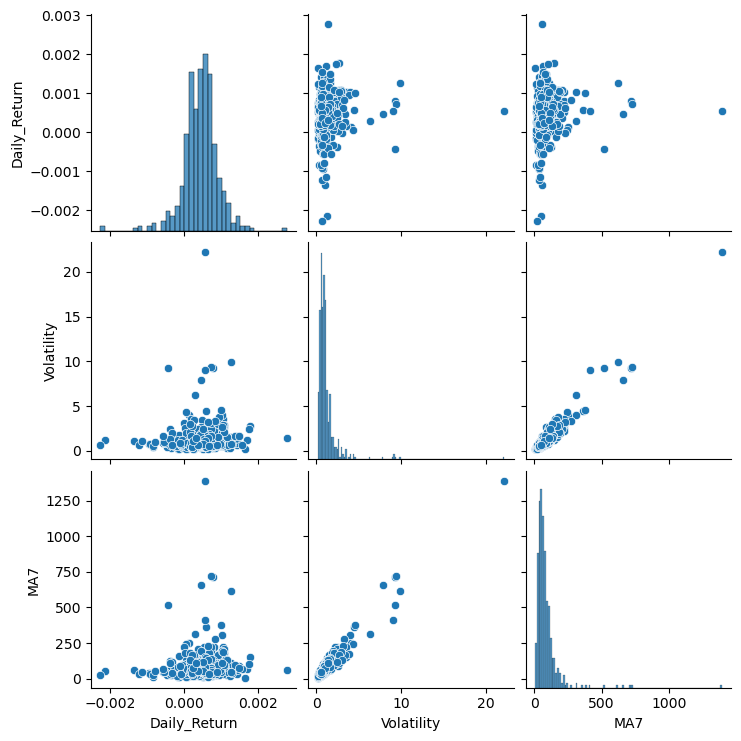

In [36]:
#determining meaningful features
sns.pairplot(grouped)


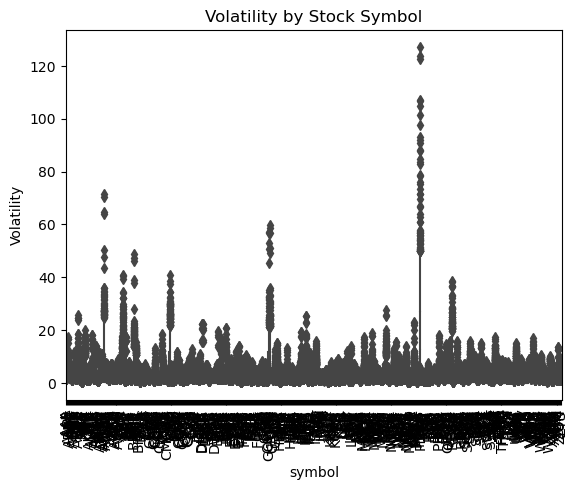

In [39]:
#boxplots per symbol
sns.boxplot(data=data, x='symbol', y='Volatility')
plt.xticks(rotation=90)
plt.title("Volatility by Stock Symbol")
plt.show()


In [1]:
!pip install thefuzz

In [2]:
!pip install python-Levenshtein

In [3]:
!pip install kneed

In [4]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime
from thefuzz import process, fuzz
from collections import defaultdict
from kneed import KneeLocator
from dateutil.relativedelta import relativedelta
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.impute import KNNImputer
from sklearn.metrics.pairwise import cosine_similarity
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import warnings
import joblib
warnings.filterwarnings('ignore')

In [5]:
# Load the dataset
data = pd.read_csv('D:/Users/Owinyez/Documents/Projos/Codveda/MyData/Stock Prices Cleaned_Alt.CSV')

# Display the first few rows of the dataset
data.head()

,symbol,date,open,high,low,close,volume,z_close,Return,Daily_Return,Daily_Return (%),Lag_1_close,Lag_7_volume,MA7,Volatility
0,A,2014-01-13,58.77,59.100,58.600,58.93,2946738,-0.270407,0.000000,0.000000,0.000000,58.93,1916160.0,57.952857,0.944541
1,A,2014-01-14,59.16,59.950,59.020,59.88,2562236,-0.261045,0.016121,0.016121,1.612082,58.93,1866651.0,58.375714,1.060532
2,A,2014-01-15,59.82,60.365,59.585,60.34,2335194,-0.256512,0.007682,0.007682,0.768203,59.88,1777472.0,58.904286,0.969396
3,A,2014-01-16,60.24,60.500,60.040,60.50,1835957,-0.254935,0.002652,0.002652,0.265164,60.34,1463208.0,59.340000,0.888894
4,A,2014-01-17,60.83,60.830,60.330,60.71,1699534,-0.252865,0.003471,0.003471,0.347107,60.50,2659468.0,59.671429,0.907954


4. Exploratory Data Analysis

In [8]:
#Initial Data Snapshot to confirm structure, data types, nulls, and basic stats.
data.head()
data.info()
data.describe()
data.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 493917 entries, 0 to 493916
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   symbol            493917 non-null  object 
 1   date              493917 non-null  object 
 2   open              493917 non-null  float64
 3   high              493917 non-null  float64
 4   low               493917 non-null  float64
 5   close             493917 non-null  float64
 6   volume            493917 non-null  int64  
 7   z_close           493917 non-null  float64
 8   Return            493917 non-null  float64
 9   Daily_Return      493917 non-null  float64
 10  Daily_Return (%)  493917 non-null  float64
 11  Lag_1_close       493917 non-null  float64
 12  Lag_7_volume      493917 non-null  float64
 13  MA7               493917 non-null  float64
 14  Volatility        493917 non-null  float64
dtypes: float64(12), int64(1), object(2)
memory usage: 56.5+ MB


symbol              0
date                0
open                0
high                0
low                 0
close               0
volume              0
z_close             0
Return              0
Daily_Return        0
Daily_Return (%)    0
Lag_1_close         0
Lag_7_volume        0
MA7                 0
Volatility          0
dtype: int64

4.1 Univariate analysis

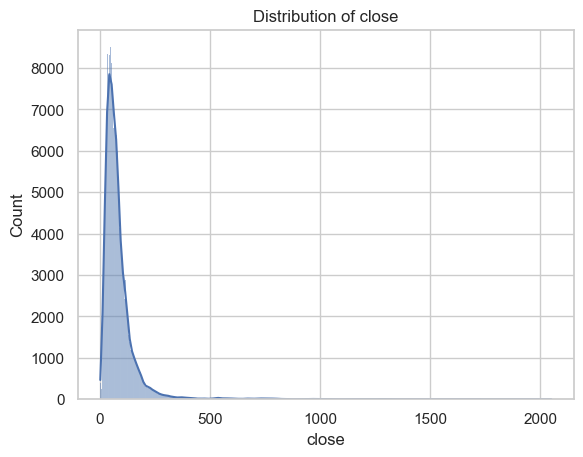

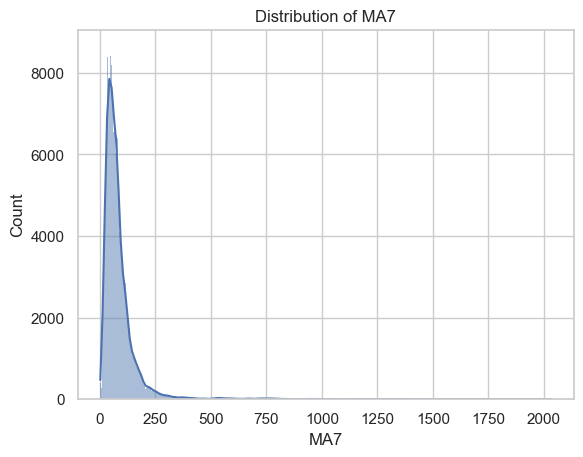

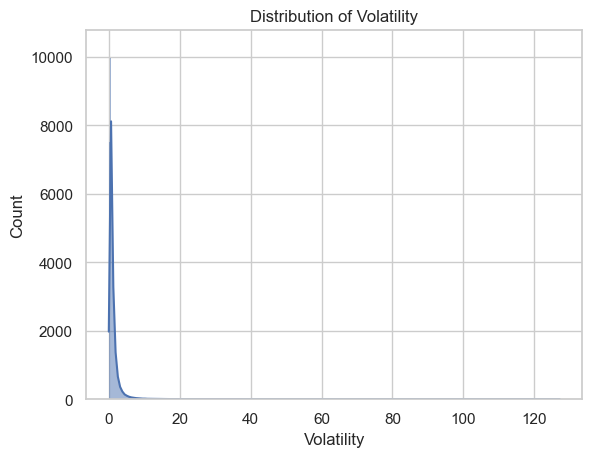

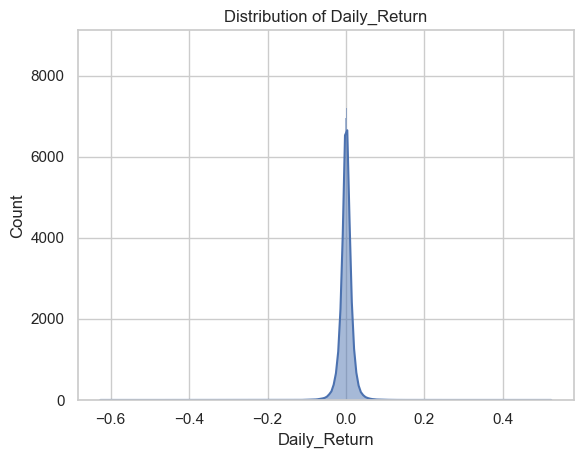

In [9]:
#price related features
for col in ['close', 'MA7', 'Volatility', 'Daily_Return']:
    sns.histplot(data[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()


In [ ]:
Most close counts range between 0 and 400 with 
Most MA7 counts range between 0 and 250
Most Volatility counts range between 0 and 10
Most Daily return counts range between -0.1 and +0.1

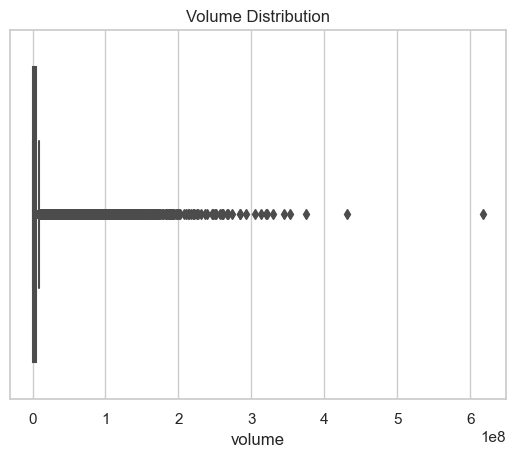

In [10]:
#Volume
sns.boxplot(data=data, x='volume')
plt.title('Volume Distribution')
plt.show()


In [ ]:
Most Volume values range between 0 and 4

4.2 Bivariate analysis

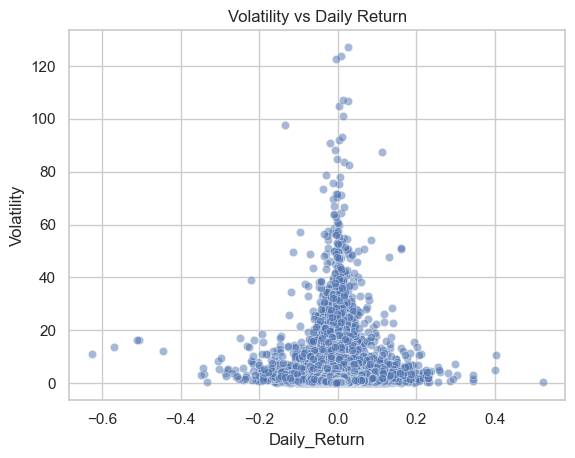

In [11]:
#relation of two features
sns.scatterplot(data=data, x='Daily_Return', y='Volatility', alpha=0.5)
plt.title('Volatility vs Daily Return')
plt.show()


4.3 Correlation matrix

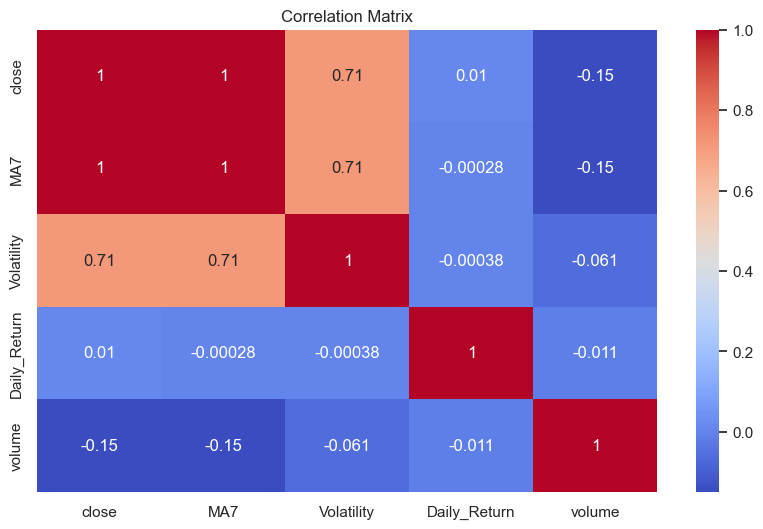

In [12]:
plt.figure(figsize=(10, 6))
sns.heatmap(data[['close', 'MA7', 'Volatility', 'Daily_Return', 'volume']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


4.4 Time Series Trends

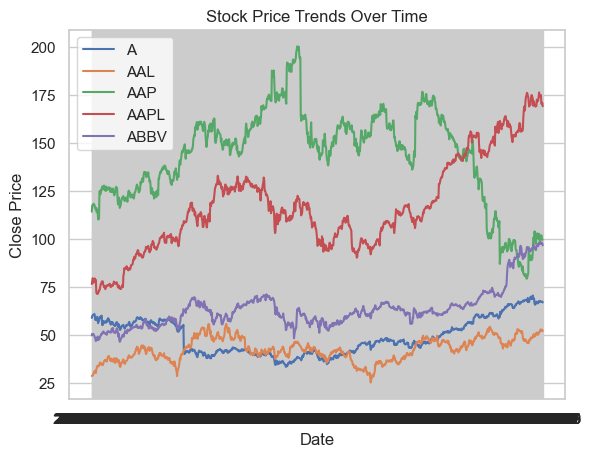

In [15]:
sample_symbols = data['symbol'].unique()[:5]  

for sym in sample_symbols:
    temp = data[data['symbol'] == sym]
    plt.plot(temp['date'], temp['close'], label=sym)

plt.legend()
plt.title("Stock Price Trends Over Time")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()


4.5 Rolling behaviour visuals

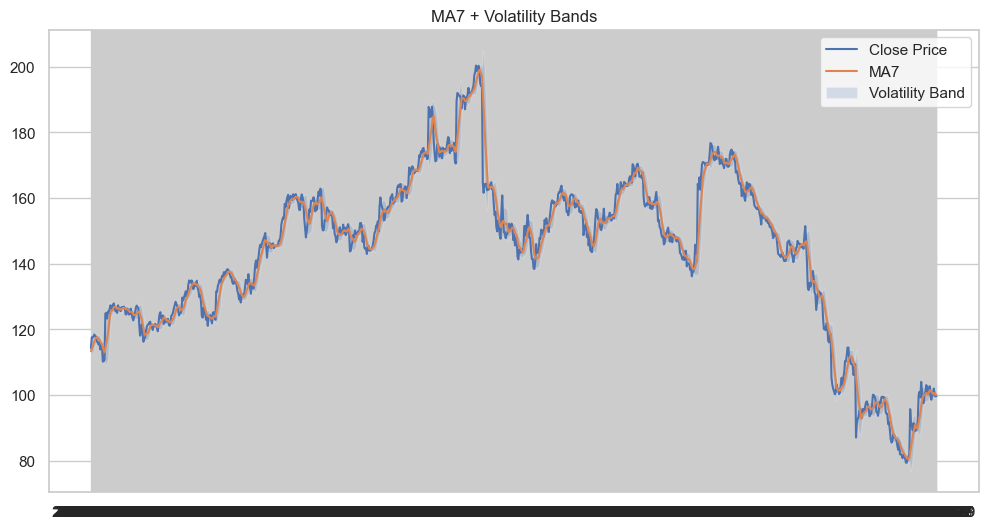

In [16]:
example = data[data['symbol'] == 'AAP']  # with highest close price as above

plt.figure(figsize=(12, 6))
plt.plot(example['date'], example['close'], label='Close Price')
plt.plot(example['date'], example['MA7'], label='MA7')
plt.fill_between(example['date'], 
                 example['MA7'] - example['Volatility'], 
                 example['MA7'] + example['Volatility'], 
                 alpha=0.2, label='Volatility Band')

plt.title('MA7 + Volatility Bands')
plt.legend()
plt.show()


4.6 Multivariate pair plot

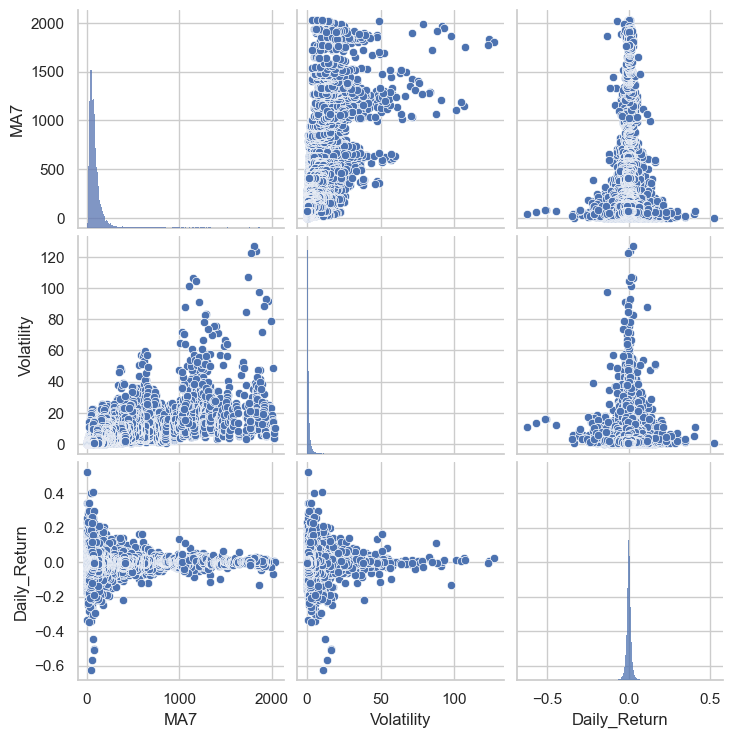

In [18]:
sns.pairplot(data[['MA7', 'Volatility', 'Daily_Return']].dropna())


4.7 Top Stocks by Movement/Volume 

In [19]:
top_volatility = data.groupby('symbol')['Volatility'].mean().sort_values(ascending=False).head(10)
top_volume = data.groupby('symbol')['volume'].mean().sort_values(ascending=False).head(10)

print("Most Volatile Stocks:\n", top_volatility)
print("\nMost Traded Stocks:\n", top_volume)


Most Volatile Stocks:
 symbol
PCLN     22.186790
AMZN      9.904142
GOOGL     9.390998
GOOG      9.247171
CMG       9.235779
REGN      9.065991
AZO       7.871781
BIIB      6.284029
MTD       4.589318
BLK       4.450063
Name: Volatility, dtype: float64

Most Traded Stocks:
 symbol
BAC     8.919211e+07
AAPL    4.493496e+07
GE      4.151481e+07
AMD     3.331137e+07
F       3.280788e+07
MSFT    3.064922e+07
FB      2.901289e+07
CHK     2.804337e+07
MU      2.781954e+07
INTC    2.715891e+07
Name: volume, dtype: float64


In [42]:
#save the new dataset
data.to_csv('D:/Users/Owinyez/Documents/Projos/Codveda/MyData/Stock Prices Cleaned_Alt.CSV', index=False)